In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [5]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

fatal: destination path 'stylegan3' already exists and is not an empty directory.


In [6]:
!ls /content/stylegan3


avg_spectra.py	 Dockerfile	  gen_video.py	metrics      training
calc_metrics.py  docs		  gui_utils	__pycache__  train.py
dataset_tool.py  environment.yml  legacy.py	README.md    visualizer.py
dnnlib		 gen_images.py	  LICENSE.txt	torch_utils  viz


In [2]:
# HIDE OUTPUT
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/"\
      "stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

!python /content/stylegan3/gen_images.py \
    --network={URL} \
  --outdir=/content/results --seeds=6600-6625

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...

Aborted!


In [8]:
# Fix: Modify upfirdn2d.py to use the reference (CPU) implementation for upfirdn2d.
# This bypasses the problematic CUDA plugin compilation.
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/upfirdn2d.py

print("Modified 'upfirdn2d.py' to use the reference implementation.")
print("Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).")

Modified 'upfirdn2d.py' to use the reference implementation.
Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).


In [9]:
# Fix: Modify filtered_lrelu.py to use the reference (CPU) implementation for filtered_lrelu.
# This bypasses the problematic CUDA plugin compilation.
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/filtered_lrelu.py

print("Modified 'filtered_lrelu.py' to use the reference implementation.")
print("Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).")

Modified 'filtered_lrelu.py' to use the reference implementation.
Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).


In [10]:
# Fix: Modify bias_act.py to use the reference (CPU) implementation for bias_act.
# This bypasses the problematic CUDA plugin compilation.
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/bias_act.py

print("Modified 'bias_act.py' to use the reference implementation.")
print("Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).")

Modified 'bias_act.py' to use the reference implementation.
Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).


In [11]:
!ls /content/results


seed6600.png  seed6606.png  seed6612.png  seed6618.png	seed6624.png
seed6601.png  seed6607.png  seed6613.png  seed6619.png	seed6625.png
seed6602.png  seed6608.png  seed6614.png  seed6620.png
seed6603.png  seed6609.png  seed6615.png  seed6621.png
seed6604.png  seed6610.png  seed6616.png  seed6622.png
seed6605.png  seed6611.png  seed6617.png  seed6623.png


In [12]:
!cp /content/results/* \
    /content/drive/My\ Drive/projects/stylegan3

cp: target '/content/drive/My Drive/projects/stylegan3' is not a directory


In [3]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8,
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs)
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const',
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [4]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


Seed 1000


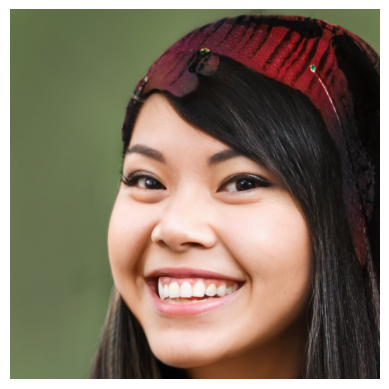

Seed 1001


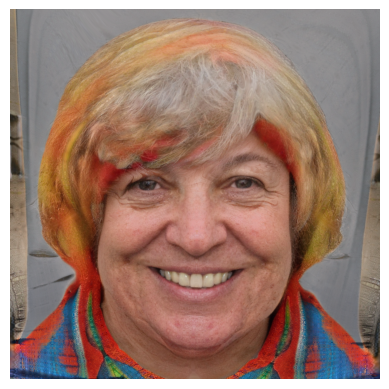

Seed 1002


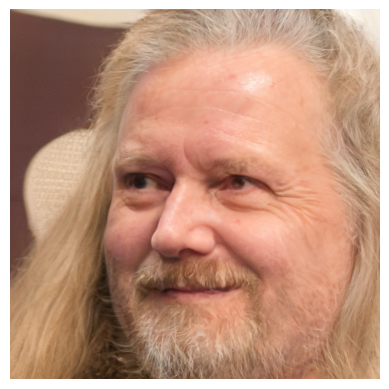

Seed 1003


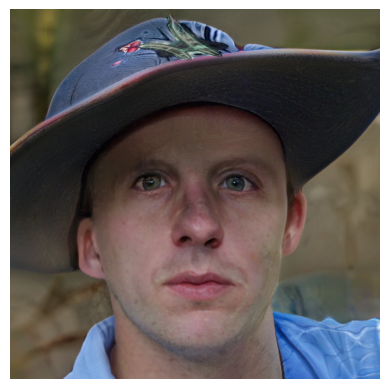

Seed 1004


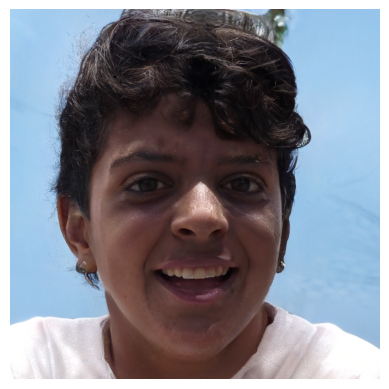

Seed 1005


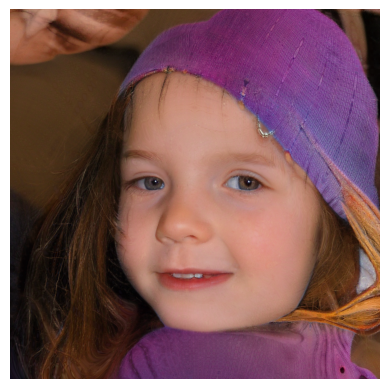

In [15]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1006

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

In [16]:
# Re-apply fix for bias_act.py after restart
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/bias_act.py
print("Re-applied fix for 'bias_act.py'.")

Re-applied fix for 'bias_act.py'.


In [17]:
# Re-apply fix for filtered_lrelu.py after restart
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/filtered_lrelu.py
print("Re-applied fix for 'filtered_lrelu.py'.")

Re-applied fix for 'filtered_lrelu.py'.


In [18]:
# Re-apply fix for upfirdn2d.py after restart
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/upfirdn2d.py
print("Re-applied fix for 'upfirdn2d.py'.")

Re-applied fix for 'upfirdn2d.py'.


In [19]:
!pip install facenet-pytorch --force-reinstall --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 183.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 260.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 212.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 327.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 240.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 239.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 248.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 274.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 425.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 258.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import pickle
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from tqdm import tqdm


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:

model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor()
])

In [8]:
img_00001 = Image.open("00001.jpg").convert("RGB")
x_00001 = transform(img_00001).unsqueeze(0).to(device)
img_00002 = Image.open("00002.jpg").convert("RGB")
x_00002 = transform(img_00002).unsqueeze(0).to(device)

In [9]:

emb_00001 = model(x_00001*2-1).detach().cpu().numpy()[0]
emb_00002 = model(x_00002*2-1).detach().cpu().numpy()[0]

(1, 512)


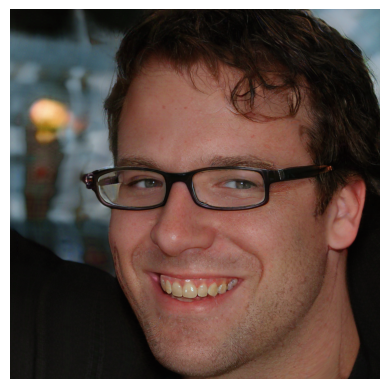

In [10]:
z = np.random.RandomState(1001).randn(1, G.z_dim)
print(z.shape)
z_random = np.random.rand(1, 512)
img = generate_image(device, G, z_random)
display_image(img)

In [11]:
def get_initial_image_tensor_uniform():
  z_random = np.random.rand(1, 512)
  img = generate_image(device, G, z_random)
  z_tensor = torch.from_numpy(z_random).float().to(device)
  z_tensor.requires_grad_(True)
  return transform(img).unsqueeze(0).to(device), z_tensor

In [12]:
image, z = get_initial_image_tensor_uniform()
num_steps = 200
optimizer = optim.Adam([z], lr=0.01)
loss_fn = nn.MSELoss()

In [13]:
def get_image_from_G(z):
  img = generate_image(device, G, z_random)
  return transform(img).unsqueeze(0).to(device)

In [14]:
def save_and_display_image(image, filename):
    final_image = torch.tanh(image.detach().cpu().squeeze(0))
    final_image = (final_image * 0.5) + 0.5

    final_image = transforms.ToPILImage()(final_image)
    final_image.save(filename)
    display(final_image)

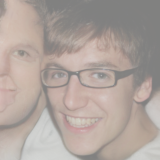

In [15]:
save_and_display_image(image, "start.png")


In [16]:
num_steps = 10

In [34]:
loss_list = []
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    normalized_image = torch.tanh(image * 2 - 1)
    current_embedding = model(get_image_from_G(z))
    # Convert emb_00001 to a PyTorch tensor, ensure float type, move to device, and add a batch dimension
    target_embedding = torch.from_numpy(emb_00001).float().to(device).unsqueeze(0)
    loss = loss_fn(current_embedding, target_embedding)

    loss.backward()
    print(f"Gradient stats: {z.grad.abs().mean().item() if z.grad is not None else 'None'}")
    optimizer.step()

    if (i + 1) % 100 == 0:
        print(f"Step [{i+1}/{num_steps}], Loss: {loss.item():.6f}")

    loss_list.append(loss.item())

final_image = image.detach().cpu().squeeze(0)
final_embedding = current_embedding.detach().cpu().squeeze(0)

 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

Gradient stats: None


 20%|██        | 2/10 [00:05<00:22,  2.78s/it]

Gradient stats: None


 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Gradient stats: None


 40%|████      | 4/10 [00:11<00:16,  2.78s/it]

Gradient stats: None


 50%|█████     | 5/10 [00:13<00:13,  2.78s/it]

Gradient stats: None


 60%|██████    | 6/10 [00:16<00:11,  2.78s/it]

Gradient stats: None


 70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

Gradient stats: None


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

Gradient stats: None


 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

Gradient stats: None


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

Gradient stats: None


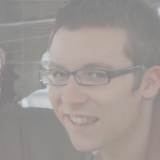

In [33]:
save_and_display_image(final_image, "end.png")


In [24]:
import torch
import torch.nn.functional as F
import torch.optim as optim

z = torch.randn(1, 512, device=device).detach()
z.requires_grad_(True)

optimizer = optim.Adam([z], lr=0.01)

target_embedding = torch.from_numpy(emb_00001).float().to(device).unsqueeze(0).detach()

print("Starting Optimization...")

for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    generated_img = G(z, None, truncation_psi=1.0, noise_mode='const')

    generated_img_resized = F.interpolate(
        generated_img,
        size=(160, 160),
        mode='bilinear',
        align_corners=False
    )

    input_tensor = torch.clamp(generated_img_resized, -1, 1)

    current_embedding = model(input_tensor)

    loss = loss_fn(current_embedding, target_embedding)

    loss.backward()

    if i == 0:
        if z.grad is None:
            print("!!! ERROR: Grad is still None. The Generator (G) might have frozen params.")
        else:
            print(f"SUCCESS: Gradient is flowing! Grad Mean: {z.grad.abs().mean().item()}")

    optimizer.step()

Starting Optimization...


  0%|          | 0/10 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.36 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.30 GiB is free. Process 245391 has 13.44 GiB memory in use. Of the allocated memory 11.60 GiB is allocated by PyTorch, and 1.71 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)